In [1]:
import numpy as np
import spotpy
import pickle
import pandas as pd
from superflexpy.implementation.root_finders.pegasus import PegasusPython
from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerPython
from superflexpy.implementation.elements.hymod import LinearReservoir
from superflexpy.implementation.elements.gr4j import ProductionStore
from superflexpy.implementation.elements.structure_elements import  Splitter, Junction
from superflexpy.framework.unit import Unit
from superflexpy.framework.element import ParameterizedElement

from datetime import datetime, timedelta
train_start = '01/10/2006'
train_end   = '30/09/2008'
basin = "01333000"

def load_data(basin,train_start,train_end):
    p = load_p(basin,train_start,train_end)
    pet = load_pet(basin,train_start,train_end)
    data = np.vstack((p,pet)).T
    return data
def load_p(basin,train_start,train_end):
    train_start_dt = datetime.strptime(train_start, '%d/%m/%Y')
    train_end = datetime.strptime(train_end, '%d/%m/%Y')
    len_seq = (train_end - train_start_dt).days + 1
    for i in range(1, 13):
        i = '0' * (1-(i // 10)) + str(i)
        try:
            f = open("data/CAMELS_US/basin_mean_forcing/daymet/"+i+"/" + basin + "_lump_cida_forcing_leap.txt")
            break
        except FileNotFoundError:
            pass
    f.readline()
    f.readline()
    f.readline()
    f.readline()
    l = f.readline().split('\t')
    x = np.zeros(len_seq)
    train_start = train_start.split('/')
    train_start.reverse()
    train_start = ' '.join(train_start)
    while l[0] != train_start+' 12':
        l = f.readline().split('\t')
    for i in range(len_seq):
        x[i] = float(l[2])
        l = f.readline().split('\t')
    return x

def load_pet(basin,train_start,train_end):
    with open("data/pet.pkl", "rb") as fp:
        results = pickle.load(fp)
        results = results[basin]
        results.index = pd.to_datetime(results.index)
        train_start = datetime.strptime(train_start, '%d/%m/%Y')
        train_end = datetime.strptime(train_end, '%d/%m/%Y')
        results = results.loc[train_start:train_end]
        results = results['PET(mm/d)'].values
        results = np.maximum(0.0,results)
    return results

# 1 - Datasets

In [2]:
def get_area(basin):
    for i in range(1,13):
        i = '0' * (1-(i // 10)) + str(i)
        try:
            fp =  open("data/CAMELS_US/basin_mean_forcing/daymet/"+i+"/"+basin+"_lump_cida_forcing_leap.txt", 'r')
            # load area from header
            fp.readline()
            fp.readline()
            area = int(fp.readline())
        except FileNotFoundError:
            pass
    return area

def load_qobs(basin,train_start,train_end):
    area = get_area(basin)
    train_start_dt = datetime.strptime(train_start, '%d/%m/%Y')
    train_end = datetime.strptime(train_end, '%d/%m/%Y')
    len_seq = (train_end - train_start_dt).days + 1
    x = np.zeros(len_seq)
    train_start = train_start.split('/')
    train_start.reverse()
    train_start = ' '.join(train_start)
    for i in range(1, 13):
        i = '0' * (1 - (i // 10)) + str(i)
        try:
            f = open("data/CAMELS_US/usgs_streamflow/"+i+"/" + basin + "_streamflow_qc.txt")
            break
        except FileNotFoundError:
            pass
    l = f.readline()[9:].split(" ")
    while ' '.join([l[i] for i in range(3)]) != train_start:
        l = f.readline()[9:].split(' ')
    for i in range(len_seq):
        x[i] = float(l[-2])
        l = f.readline()[9:].split(' ')
    x = 28316846.592 * x * 86400 / (area * 10**6)
    return x

P    = load_p(basin, train_start, train_end)
Ep   = load_pet(basin, train_start, train_end)
Qobs = load_qobs(basin, train_start, train_end)

In [ ]:
import pandas as pd
for basin in ["02027500" ,"03026500","05487980","03186500","08175000"]:
    P = load_p(basin, '01/10/2001', '30/09/2008')
    Ep = load_pet(basin, '01/10/2001', '30/09/2008')
    Qobs = load_qobs(basin, '01/10/2001', '30/09/2008')
    x = pd.DataFrame({
        'P': P,
        'Ep': Ep,
        'Qobs': Qobs,
        'dates': pd.date_range(start='2001-10-01', periods=len(P))
    })
    x.to_csv(basin+'.csv')

# 2 - Superflex model creation

In [ ]:
class ParameterizedSingleFluxSplitter(ParameterizedElement):
    _num_downstream = 2
    _num_upstream = 1
    
    def set_input(self, input):

        self.input = {'Q_in': input[0]}

    def get_output(self, solve=True):

        split_par = self._parameters[self._prefix_parameters + 'split-par']

        output1 = [self.input['Q_in'] * split_par]
        output2 = [self.input['Q_in'] * (1 - split_par)]
        
        return [output1, output2]   
    

def create_superflex_model():
    # Initialize numercal routines
    root_finder = PegasusPython()
    numeric_approximator = ImplicitEulerPython(root_finder=root_finder)

    # Initialize the elements
    lr_1 = LinearReservoir(
        parameters={'k': 0.5},
        states={'S0': 0.0},
        approximation=numeric_approximator,
        id='LR-1'
    )

    lr_2 = LinearReservoir(
        parameters={'k': 4.0},
        states={'S0': 0.0},
        approximation=numeric_approximator,
        id='LR-2'
    )

    tr = ProductionStore(
        parameters={'x1': 20.0, 'alpha': 2.0,
                    'beta': 2.0, 'ni': 0.0},
        states={'S0': 0.0},
        approximation=numeric_approximator,
        id='TR'
    )
    splitter = ParameterizedSingleFluxSplitter(
                        parameters={'split-par': 0.9},
                        id='spl'
    )

    junction = Junction(direction=[[0, 0]], # Third output
                        id='jun')

    model = Unit(layers=[[tr],
                        [splitter],
                        [lr_1, lr_2],
                        [junction]],
                id='model')
    return model

sf_model = create_superflex_model()

# 3 - Metric

In [ ]:
def obj_fun_nse(obs, sim):
    idx = (~np.isnan(sim)) & (~np.isnan(obs))
    obs = obs[idx]
    sim = sim[idx]
    denominator = ((obs - obs.mean())**2).sum()
    numerator = ((sim - obs)**2).sum()
    value = numerator / denominator
    return float(value)

# 4 - Spotpy model

In [ ]:
class spotpy_model(object):

    def __init__(self, model, inputs, dt, observations, parameters, parameter_names, output_index, 
                 warm_up = 365):

        self._model = model
        self._model.set_input(inputs)
        self._model.set_timestep(dt)

        self._parameters = parameters
        self._parameter_names = parameter_names
        self._observarions = observations
        self._output_index = output_index
        
        self._warm_up = int(warm_up)
        
    def parameters(self):
        return spotpy.parameter.generate(self._parameters)
    
    def simulation(self, parameters):

        named_parameters = {}
        for p_name, p in zip(self._parameter_names, parameters):
            named_parameters[p_name] = p

        self._model.set_parameters(named_parameters)
        self._model.reset_states()
        output = self._model.get_output()

        return output[self._output_index]
    
    def evaluation(self):
        return self._observarions
    
    # Here you can use a pre-defined objective function from spotpy, or you can write down your own:    
    def objectivefunction(self, simulation, evaluation):        
        evaluation_used = evaluation[self._warm_up + 1:]
        simulation_used = simulation[self._warm_up + 1:]
        obj_fun = obj_fun_nse(evaluation_used, simulation_used)
        
        return obj_fun

In [ ]:
spotpy_sf = spotpy_model(
    model=sf_model,
    inputs=[Ep,P],
    dt=1.0,
    observations = Qobs,
    parameters=[
        spotpy.parameter.Uniform('model_TR_x1', 1.0, 500.0),
        spotpy.parameter.Uniform('model_LR-1_k', 0.01, 50.0),
        spotpy.parameter.Uniform('model_LR-2_k', 0.01, 50.0),
        spotpy.parameter.Uniform('model_spl_split-par', 0.0, 1.0)
    ],
    parameter_names=['model_TR_x1','model_LR-1_k','model_LR-2_k','model_spl_split-par'],
    output_index=0,
    warm_up=0
)

# 5 - Calibration

In [ ]:
sampler = spotpy.algorithms.sceua(spotpy_sf, dbname='calibration', dbformat='csv')
sampler.sample(repetitions=1000)

In [ ]:
parameter_names = ['TR_smax','LR1_k','LR2_k','Splitter1','Splitter2']
sf_model_parameters = [208.061, 19.2237, 0.112066, 0.112686] #[377.757, 24.4519, 0.144759, 0.179659]
sf_model_parameters.append(1-sf_model_parameters[-1])
if sf_model_parameters[1]<sf_model_parameters[2]:
    sf_model_parameters[1], sf_model_parameters[2] = sf_model_parameters[2],sf_model_parameters[1]
    sf_model_parameters[3], sf_model_parameters[4] = sf_model_parameters[4],sf_model_parameters[3]


# 6 - Running NH

In [ ]:
from neuralhydrology.nh_run import start_run
from pathlib import Path
for basin in ['01333000', "02027500", "03026500", "05487980", "03186500", "08175000"]:
    with open("examples/07-Superflex/1_basin_list.txt",'w') as f:
        f.write(basin)
    f1 =  open("examples/07-Superflex/experiment.yml", 'w')
    f2 =  open("examples/07-Superflex/example4.yml", 'r')
    l = f2.readline()
    while l[:7] != 'run_dir':
        f1.write(l)
        l = f2.readline()
    f1.write('run_dir: runs/' + basin + '\n')
    l = f2.readline()
    while l:
        f1.write(l)
        l = f2.readline()
    f1.close()
    f2.close()
    for _ in range(10):
        start_run(config_file=Path("examples/07-Superflex/experiment.yml", gpu=-1))

# 7 - Analysis


# 7.0 - Analysis tools

In [ ]:
import pickle
import numpy as np
import pandas as pd
import xarray as xr
from os import listdir
from torch import load, nn, tensor, float32
from neuralhydrology.datasetzoo.camelsus import load_camels_us_attributes
from superflexpy.implementation.root_finders.pegasus import PegasusPython
from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerPython
from superflexpy.implementation.elements.hymod import LinearReservoir
from superflexpy.implementation.elements.gr4j import ProductionStore
from superflexpy.implementation.elements.structure_elements import Splitter, Junction
from superflexpy.framework.unit import Unit
from datetime import datetime, timedelta

def load_p(basin, train_start, train_end):
    train_start_dt = datetime.strptime(train_start, '%d/%m/%Y')
    train_end = datetime.strptime(train_end, '%d/%m/%Y')
    len_seq = (train_end - train_start_dt).days + 1
    for i in range(1, 13):
        i = '0' * (1 - (i // 10)) + str(i)
        try:
            f = open("data/CAMELS_US/basin_mean_forcing/daymet/" + i + "/" + basin + "_lump_cida_forcing_leap.txt")
            break
        except FileNotFoundError:
            pass
    f.readline()
    f.readline()
    f.readline()
    f.readline()
    l = f.readline().split('\t')
    x = np.zeros(len_seq)
    train_start = train_start.split('/')
    train_start.reverse()
    train_start = ' '.join(train_start)
    while l[0] != train_start + ' 12':
        l = f.readline().split('\t')
    for i in range(len_seq):
        x[i] = float(l[2])
        l = f.readline().split('\t')
    return x

def load_pet(basin, train_start, train_end):
    with open("data/pet.pkl", "rb") as fp:
        results = pickle.load(fp)
        results = results[basin]
        results.index = pd.to_datetime(results.index)
        train_start = datetime.strptime(train_start, '%d/%m/%Y')
        train_end = datetime.strptime(train_end, '%d/%m/%Y')
        results = results.loc[train_start:train_end]
        results = results['PET(mm/d)'].values
        results = np.maximum(0.0, results)
    return results

def epoch_int_to_str(nb_epochs):
    nb_epochs = str(nb_epochs)
    nb_epochs = (3 - len(nb_epochs)) * '0' + nb_epochs
    return nb_epochs

def to_xarray(arr, start_date, time_step_value=1):
    start_date = datetime.strptime(start_date, '%d/%m/%Y')
    start_date = start_date.strftime('%Y-%m-%d')
    dates = pd.date_range(start=start_date, periods=len(arr))
    return xr.DataArray(arr, coords={'date': dates, 'time_step': time_step_value}, dims=['date'])

def get_nh_validation(run_dir, basins, first_epoch, last_epoch=None, epoch_interval=1):
    """return a dict : res[basin_str][epoch_int] -> iterable over timesteps"""
    if last_epoch is None:
        last_epoch = first_epoch
        epoch_interval = 1
    res = {}
    for basin in basins:
        res[basin] = {}
        for epoch in range(first_epoch, last_epoch + 1, epoch_interval):
            nb_epochs = epoch_int_to_str(epoch)
            with open(run_dir + "/validation/model_epoch" + nb_epochs + "/validation_results.p", "rb") as fp:
                results = pickle.load(fp)
                qsim = results[basin]['1D']['xr']['QObs(mm/d)_sim'].squeeze().values
                res[basin][epoch] = qsim
    return res

def get_nh_observed(run_dir, basins, first_epoch=1):
    """return a dict : res[basin_str] -> iterable over timesteps"""
    res = {}
    for basin in basins:
        res[basin] = []
        nb_epochs = epoch_int_to_str(first_epoch)
        with open(run_dir + "/validation/model_epoch" + nb_epochs + "/validation_results.p", "rb") as fp:
            results = pickle.load(fp)
            qobs = results[basin]['1D']['xr']['QObs(mm/d)_obs'].squeeze().values
            res[basin] = qobs
    return res

def get_nh_metrics(run_dir, basins, first_epoch, last_epoch=None, epoch_interval=1):
    """return a dict : res[basin_str]["NSE" or "KGE"] -> iterable over epochs"""
    if last_epoch is None:
        last_epoch = first_epoch
        epoch_interval = 1
    res = {}
    for basin in basins:
        res[basin] = {'NSE': [], 'KGE': []}
        for nb_epochs in range(epoch_interval, last_epoch + 1, epoch_interval):
            nb_epochs = epoch_int_to_str(nb_epochs)
            with open(run_dir + "/validation/model_epoch" + nb_epochs + "/validation_results.p", "rb") as fp:
                results = pickle.load(fp)
                nse_nh = results[basin]['1D']['NSE']
                kge_nh = results[basin]['1D']['KGE']
            res[basin]['NSE'].append(nse_nh)
            res[basin]['KGE'].append(kge_nh)
    return res

def scale_output(x, min_val, max_val):
    scaled_x = x * (max_val - min_val) + min_val
    return scaled_x.detach().item()

class MyModel(nn.Module):

    def __init__(self):
        #torch.nn.Sequential(torch.nn.Linear(in_features=static_inputs_size, out_features=20),
        #                    torch.nn.Sigmoid(), torch.nn.Dropout(p=0.0),
        #                    torch.nn.Linear(in_features=20, out_features=total_parameters),
        #                    torch.nn.Sigmoid())
        super(MyModel, self).__init__()
        self.parameterization = nn.Sequential(nn.Linear(in_features=3, out_features=20),
                                              nn.Sigmoid(), nn.Dropout(p=0.0), nn.Linear(in_features=20,
                                                                                         out_features=20), nn.Sigmoid(),
                                              nn.Linear(in_features=20, out_features=5), nn.Sigmoid())

    def forward(self, x):
        return self.parameterization(x)

def get_nh_parameters(run_dir, basins, parameter_names, first_epoch, last_epoch=None, epoch_interval=1):
    """return a dict : res[basin_str][parameter_name_str] -> iterable over epochs
    # WORKS for arch1 only, otherwise => change 'MyModel' class"""
    if last_epoch is None:
        last_epoch = first_epoch
        epoch_interval = 1
    res = {}
    all_x_s = load_camels_us_attributes("data/CAMELS_US", basins)
    for ib, basin in enumerate(basins):
        x_s = tensor(all_x_s.loc[basin, ["baseflow_index", "high_q_freq", "aridity"]].values.astype(float), dtype=float32)
        res[basin] = {}
        for pn in parameter_names:
            res[basin][pn] = []
        for nb_epochs in range(epoch_interval, last_epoch + 1, epoch_interval):
            epoch_str = epoch_int_to_str(nb_epochs)
            ordereddict = load(run_dir + '/model_epoch' + epoch_str + '.pt')
            m = MyModel()
            m.load_state_dict(ordereddict)
            params_epoch = m(x_s)
            if len(basins) > 1:
                params_epoch = params_epoch[ib]
            res[basin]["TR_smax"].append(scale_output(params_epoch[0], 1.0, 500.0))
            r1, r2 = scale_output(params_epoch[3], 0.01, 50.0), scale_output(params_epoch[4], 0.01, 50.0)
            weights = params_epoch[1:3]
            row_sums = weights.sum()
            normalized_weights = weights / row_sums
            p1, p2 = normalized_weights[0].detach().item(), normalized_weights[1].detach().item()
            if r1<r2:
                r1, r2 = r2, r1
                p1, p2 = p2, p1
            res[basin]["LR1_k"  ].append(r1)
            res[basin]["LR2_k"].append(r2)
            res[basin]["Splitter1"].append(p1)
            res[basin]["Splitter2"].append(p2)
    return res

def get_of_parameters(basin):
    with open('runs/openFlex/demo/01/output_' + basin + '/par_Mraf_cal.dat') as f:
        l = f.readline()
        l = f.readline()
        l.replace(' ', '')
        smax_of = float(l[:-1])
        l = f.readline()
        l.replace(' ', '')
        w = float(l[:-1])
        l = f.readline()
        l.replace(' ', '')
        r1_of = float(l[:-1])
        l = f.readline()
        l.replace(' ', '')
        r2_of = float(l[:-1])
    if r1_of < r2_of:
        r2_of, r1_of = r1_of, r2_of
    else:
        w = 1.0-w
    return {"TR_smax": smax_of, 'LR1_k': r1_of, 'LR2_k': r2_of, "Splitter1": w, "Splitter2": 1.0-w}

def get_of_nse(basin):
    with open('runs/openFlex/demo/01/output_' + basin + '/par_Mraf_cal.dat') as f:
        for _ in range(8):
            l = f.readline()
        l = l.replace(" ", "")
        l = l[l.index("=") + 1:]
        l = float(l)
    return l

def get_sf_validation(basin, validation_start, validation_end,sf_model_parameters, seq_length=365, predict_last_n=1):
    root_finder = PegasusPython()
    numeric_approximator = ImplicitEulerPython(root_finder=root_finder)
    lr_1 = LinearReservoir(parameters={'k': sf_model_parameters[1]},
                        states={'S0': 0.0},
                        approximation=numeric_approximator,
                        id='LR-1')
    lr_2 = LinearReservoir(parameters={'k': sf_model_parameters[2]},
                        states={'S0': 0.0},
                        approximation=numeric_approximator,
                        id='LR-2')
    tr = ProductionStore(parameters={
        'x1': sf_model_parameters[0],
        'alpha': 2.0,
        'beta': 2.0,
        'ni': 0.0
        },
        states={'S0': 0.0},
        approximation=numeric_approximator,
        id='TR')
    splitter = Splitter(weight=[[sf_model_parameters[3]], [1 - sf_model_parameters[3]]], direction=[[0], [0]], id='spl')

    junction = Junction(
        direction=[[0, 0]],  # Third output
        id='jun')

    model_sf = Unit(layers=[[tr], [splitter], [lr_1, lr_2], [junction]], id='model')

    validation_start = datetime.strptime(validation_start, '%d/%m/%Y')
    validation_start = validation_start - timedelta(days=seq_length - predict_last_n)
    validation_start = validation_start.strftime('%d/%m/%Y')
    #validation_end   = (datetime.strptime('01/10/2002', '%d/%m/%Y') + timedelta(days=1)).strftime('%d/%m/%Y')

    P = load_p(basin, validation_start, validation_end)
    Ep = load_pet(basin, validation_start, validation_end)
    output_sf = []
    for offset in range(0, len(Ep) - seq_length + 1, predict_last_n):
        model_sf.reset_states()
        model_sf.set_input([Ep[offset:offset + seq_length], P[offset:offset + seq_length]])
        model_sf.set_timestep(1.0)
        output_sf += model_sf.get_output()[0][-predict_last_n:].tolist()
    output_sf = np.array(output_sf)
    return output_sf

## 7.1 - Neuralhydrology outflow and metrics analysis

In [ ]:
#===========SET THIS=================
run_dir = "runs/01333000/run_2204_135139"
first_epoch = 1
last_epoch = 10
epoch_interval = 1
#basins = ["01510000",
#          "02027500",
#          "03026500",
#          "05487980",
#          "06853800",
#          "08175000"]
basins = ['01333000', '01333000']
#------------------------------------

import matplotlib.pyplot as plt
fig, ax = plt.subplots(len(basins), figsize=(20, 10))
sim = get_nh_validation(run_dir, basins,first_epoch, last_epoch, epoch_interval)
obs = get_nh_observed(run_dir, basins, first_epoch)
for ib, basin in enumerate(basins):
    for nb_epochs in range(1, last_epoch + 1, epoch_interval):
        ax[ib].plot(sim[basin][nb_epochs],label='epoch '+str(nb_epochs))
    ax[ib].plot(obs[basin], label='obs')
    ax[ib].set_title(basin)
plt.legend()
plt.show()

fig, ax = plt.subplots(len(basins), figsize=(20, 10))
ax2 = [None for _ in basins]
mets = get_nh_metrics(run_dir, basins, first_epoch, last_epoch, epoch_interval)

for ib, basin in enumerate(basins):
    ax[ib].set_xlabel('epochs')
    ax[ib].set_ylabel('NSE', color='tab:red')
    ax[ib].plot(range(first_epoch, last_epoch+1, epoch_interval),mets[basin]['NSE'],color='tab:red')
    ax2[ib] = ax[ib].twinx()
    ax2[ib].set_ylabel('KGE', color='tab:blue')
    ax[ib].plot(range(first_epoch, last_epoch+1, epoch_interval),mets[basin]['KGE'],color='tab:blue')
    ax[ib].set_title(basin)
plt.show()

## 7.2 - Neuralhydrology parameters analysis

In [ ]:
parameter_names = ['TR_smax', 'LR1_k', 'LR2_k', 'Splitter1', 'Splitter2']
nh_model_parameters = []
basin = '01333000'
for run_dir in listdir('runs/'+basin):
    nh_model_parameters.append(get_nh_parameters('runs/'+basin+'/'+run_dir, [basin], parameter_names, first_epoch, last_epoch, epoch_interval))

fig, ax = plt.subplots(len(parameter_names), figsize=(20, 20))
for ip, param in enumerate(parameter_names):
    for r in range(5):
        ax[ip].plot(range(first_epoch, last_epoch + 1, epoch_interval), nh_model_parameters[r][basin][param], label='run'+str(r))
        ax[ip].set_title(param)
plt.legend()
plt.show()


## 7.3 - Comparison with Superflex

In [ ]:
from neuralhydrology.evaluation import metrics
import seaborn as sns

basin = "01333000"
validation_start = '01/10/2006'
validation_end   = '30/09/2008'
warmup = 0
last_epoch = 7

output_sf = get_sf_validation(basin, validation_start, validation_end, [208.061, 19.2237, 0.112066, 0.112686])
output_sf_xarray = to_xarray(output_sf, validation_start)

fig, ax = plt.subplots(1,1, figsize=(20, 10))
nse_nh = get_nh_metrics(run_dir, basins=[basin], first_epoch=last_epoch)[basin]['NSE'][-1]
qobs =  get_nh_observed(run_dir, [basin], first_epoch)
qobs_xarray = to_xarray(qobs[basin], validation_start)
nse_sf = metrics.nse(qobs_xarray,output_sf_xarray)
qsim = get_nh_validation(run_dir, basins=[basin], first_epoch=last_epoch)[basin][last_epoch]

print("NSE NH:",nse_nh, "\nNSE SF:",nse_sf,'\n')

#for pnames,nh,sf in zip(parameter_names,nh_model_parameters,sf_model_parameters):
#    print(pnames.ljust(10),'NH:',str(round(nh,5)).ljust(10),'SF:',str(round(sf,5)).ljust(10))


sns.set_theme(style="darkgrid")
sns.lineplot(data=pd.DataFrame({'obs':qobs[basin][warmup:],
                                "nh": qsim[warmup:],
                                "sf": output_sf[warmup:]}))

# 8 - Batch comparison

## 8.1 - Against Fortran

In [ ]:
import seaborn as sns
parameter_names = ['TR_smax', 'LR1_k', 'LR2_k', 'Splitter1', 'Splitter2']
# Load SF parameters
for basin in ['01333000','02027500']:
    algo = []
    data = {'NSE':[], 'TR_smax':[], 'LR1_k':[], 'LR2_k':[], 'Splitter1':[]}
    with open('runs/openFlex/demo/01/output_'+basin+'/par_Mraf_cal.dat') as f:
        algo.append("OF")
        data['NSE'].append(get_of_nse(basin))
        params_of = get_of_parameters(basin)
        data['TR_smax'].append(params_of['TR_smax'])
        data['LR1_k'].append(params_of['LR1_k'])
        data['LR2_k'].append(params_of['LR2_k'])
        data['Splitter1'].append(params_of['Splitter1'])

    nb_epochs = 10
    for run_dir in listdir('runs/'+basin):
        algo.append("NH")
        data['NSE'].append(get_nh_metrics('runs/'+basin+'/'+run_dir,[basin],nb_epochs)[basin]['NSE'][-1])
        params_nh = get_nh_parameters('runs/'+basin+'/'+run_dir, [basin], parameter_names,10)
        data['TR_smax'].append(params_nh[basin]['TR_smax'][-1])
        data['LR1_k'].append(params_nh[basin]['LR1_k'][-1])
        data['LR2_k'].append(params_nh[basin]['LR2_k'][-1])
        data['Splitter1'].append(params_nh[basin]['Splitter1'][-1])
    sns.set_theme(style="ticks", palette="pastel")
    f, axes = plt.subplots(1, len(parameter_names),figsize=(20, 10))
    for i,n in enumerate(['NSE'] + parameter_names[:-1]):
        x = pd.DataFrame({
            'value': data[n],
            'algo': algo
        })
        # Draw a nested boxplot to show bills by day and time
        sns.boxplot(x=[n]*len(algo),
                    y="value",
                    hue="algo",
                    data=x,
                    ax=axes[i])

Comparing forward pass for models with exactly the same parameter values:
- 1. Fortran
- 2. Neuralhydrology
- 3. A simulated model
- 4. Superflex

In [3]:
from neuralhydrology.nh_run import start_run
from neuralhydrology.modelzoo import Superflex
from neuralhydrology.utils.config import Config
from neuralhydrology.evaluation import metrics

from pathlib import Path
from torch import tensor
from numpy import reshape, dstack
import matplotlib.pyplot as plt

# 1. - Neuralhydrology --------------------------------------
cfg = Config(Path('examples/07-Superflex/example4.yml'))

m = Superflex(cfg)

p = load_p('01333000','01/10/2005', '30/09/2008')
l = len(p)
p = reshape(p, (1, l, 1))
ep = load_pet('01333000', '01/10/2005', '30/09/2008')
ep = reshape(ep, (1, len(ep), 1))
xd = dstack((p,ep))
qobs = load_qobs('01333000', '01/10/2005', '30/09/2008')
qobs = reshape(qobs,(1,len(qobs),1))
dates = pd.date_range(start='2005-10-01', periods=l)

x_s = tensor([[0.7204, 0.5716, 4.5000]])
per_basin_target_stds = tensor([[[1.5724]]])

length = cfg.seq_length

nh_output= []

for i in range(length,l):
    if int(100*(i-length)/(l-length)) % 10 == 0:
        print(int(100 * (i - length) / (l - length)), '%',end='\r')
    x_d = tensor(xd[: , i - length:i, :])
    y = tensor(qobs[i-length:i])
    date = pd.date_range(start=dates[i-length], periods=length)
    data = {
        'x_s': x_s,
        'y': y,
        'date': date,
        'x_d': x_d,
        'per_basin_target_stds' : per_basin_target_stds
    }
    o = m(data)['y_hat']
    o = o[-1][-1][-1].item()
    nh_output.append(o)
print()

# 2. - Frotran --------------------------------------
fr_output = []
with open('runs/openFlex/demo/01/output_'+'01333000'+'/res_Mraf.dat') as f:
    for i in range(369):
        l = f.readline()
    while l:
        fr_output.append(float(l.split('    ')[6]))
        l = f.readline()


90 %


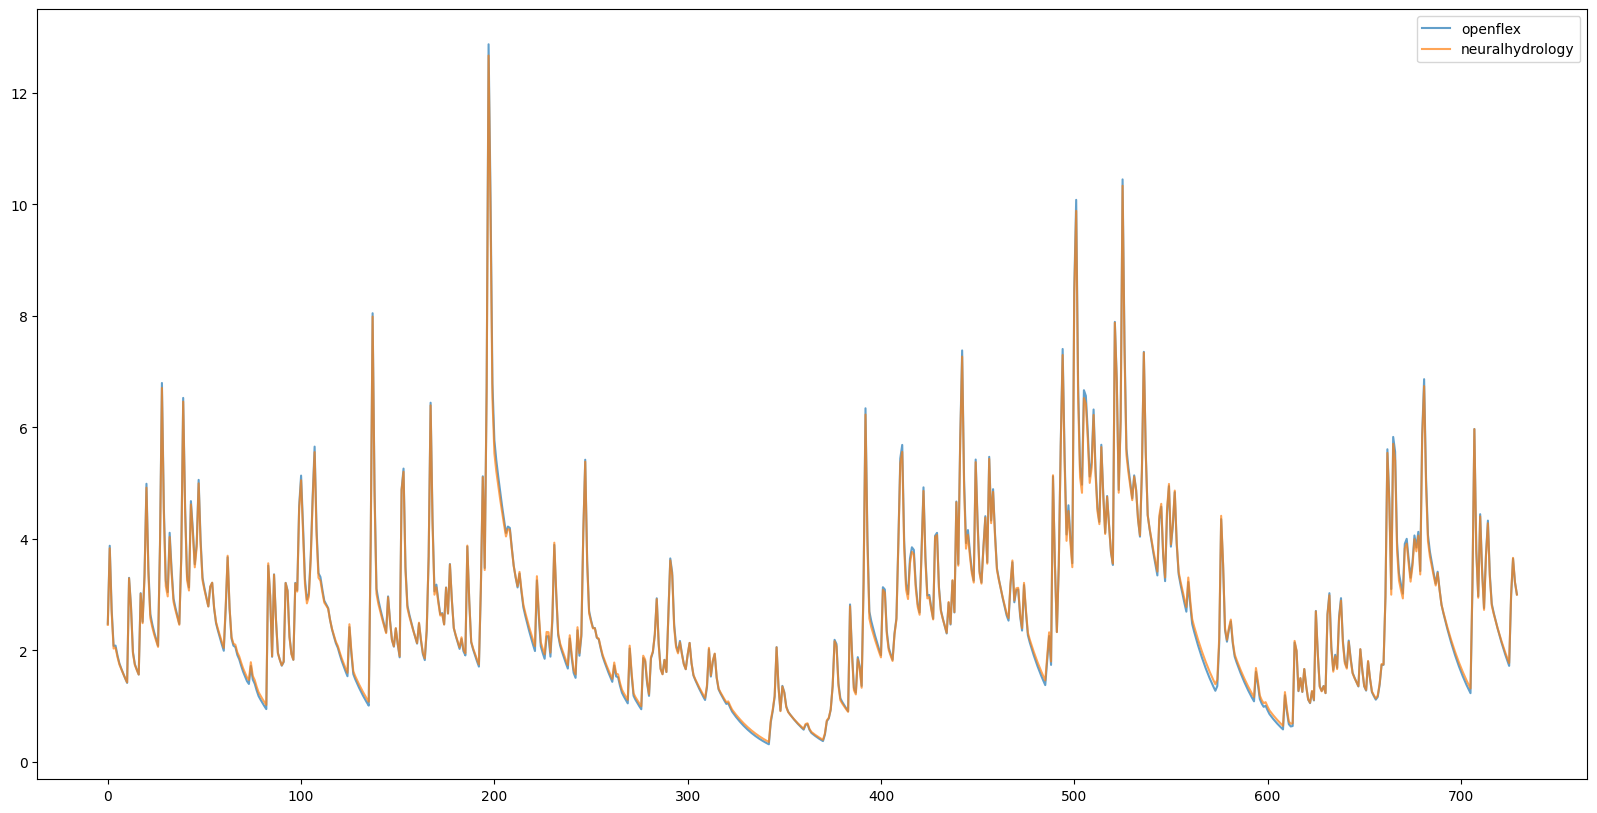

In [4]:
# Plot ------------------------------------------------
f, ax = plt.subplots(figsize=(20, 10))
ax.plot(fr_output[:-1], alpha=0.7, label='openflex')
ax.plot(nh_output[1:] , alpha=0.7, label='neuralhydrology')
#ax.plot(output_sf, '--', alpha=0.5, label='sf')
#ax.plot(sim, '--', alpha=0.5, label='sim')
ax.legend()
plt.show()